# Produktions/Lagerplanung

Wir implementieren hier ein einfaches Produktions- und Lagerhaltungsproblem. 


Eine Firma stellt über einen Planungszeitraum ein Produkt her, so dass die jeweilige Nachfrage befriedigt wird und so dass die Kosten (Produktions- und Lagerkosten) so gering wie möglich sind. Folgende Daten sind gegeben:
<ul>
    <li>$T$: Zeithorizont, z.B. $T=12$ Monate</li>
    <li>$d_t$: Nachfrage in Periode $t$</li>
    <li>$p_t$: Bestell-/Produktionskosten pro Einheit in Periode $t$</li>
    <li>$h_t$: Lagerkosten pro Einheit in Periode~$t$</li>
</ul>

Bestimmt werden sollen 
<ul>
    <li>$x_t$: Bestell-/Produktionsmenge in Periode $t$</li>
    <li>$s_t$: Vorrat (Lagermenge) am Ende von Periode $t$</li>
</ul>

Als lineares Programm erhält man:

$$
\begin{array}{lll}
\min & \sum_{t=1}^Tp_tx_t+\sum_{t=1}^Th_ts_t & \\
\text{unter }& 
s_{t-1}+x_t= d_t+s_t & \qquad t=1,\ldots,T\\
&x_t,s_t\geq 0 & \qquad t=1,\ldots,T\\
&s_0=0 &
\end{array}
$$

In [1]:
# Zum Installieren in google colab. Wenn Sie lokal mip installiert haben, kommentieren Sie die nächste Zeile aus.
!pip install mip

import mip
import random  ## Standard-Bibliothek zur Erzeugung von Zufallszahlen

### Wir werden die Daten plotten und müssen dafür matplotlib einbinden
import matplotlib.pyplot as plt
### Wir benutzen das fivethirtyeight style, damit die plots ein bisschen hübscher aussehen
plt.style.use('fivethirtyeight')

Wie immer brauchen wir eine Beispielsinstanz, die wir zufällig erzeugen. Zunächst einmal generieren wir nur Nachfrage $d$, Produktionskosten $p$ und Lagerkosten $h$.

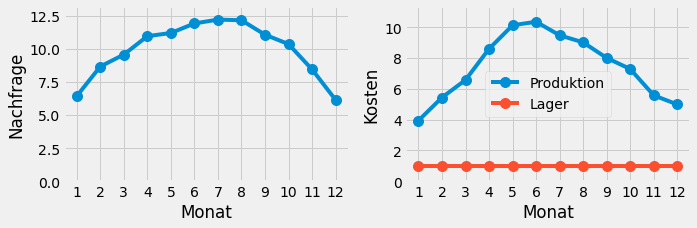

In [2]:
T=12+1
def rnd_instance():
    a=4/T**2*8
    b=3
    aa=4/T**2*8
    bb=3
    d=[round(-a*x*(x-T)+b+random.random()*2,2) for x in range(T)]
    p=[round(-aa*(x-1)*(x-T+1)+bb+random.random()*2,2) for x in range(T)]
    h=[1 for _ in range(T)]
    d[0],p[0],h[0]=0,0,0  ## dummy Werte
    return d,p,h

### Wir plotten die Daten
d,p,h=rnd_instance()
fig,axs=plt.subplots(1,2,figsize=(10,3))
axs[0].plot(range(1,T),d[1:],"o-",markersize=10)
axs[0].set_xticks(range(1,T))
axs[0].set_ylim(0,max(d)+1)
axs[0].set_ylabel('Nachfrage')
axs[0].set_xlabel('Monat')
axs[1].plot(range(1,T),p[1:],"o-",markersize=10,label="Produktion")
axs[1].plot(range(1,T),h[1:],"o-",markersize=10,label="Lager")
axs[1].legend()
axs[1].set_xticks(range(1,T))
axs[1].set_ylabel('Kosten')
axs[1].set_xlabel('Monat')
axs[1].set_ylim(0,max(p)+1)
plt.show()

Wir beginnen mit dem linearen Programm. Dazu benötigen wir Produktionsvariablen $x_t$ und Lagervariablen $s_t$. Die default-Einstellungen für Variablen setzen eine untere Schranken von $0$ fest -- das trifft sich gut, da wir $x_t\geq 0$ und $s_t\geq 0$ eh voraussetzen müssen. 

In [3]:
m=mip.Model()
x=[m.add_var() for _ in range(T)]
s=[m.add_var() for _ in range(T)]

Das Optimierungsziel ist die Minimierung der Kosten, die sich aus den Produktionskosten und den Lagerkosten zusammen setzen.

In [4]:
m.objective=mip.minimize(mip.xsum(x[t]*p[t]+s[t]*h[t] for t in range(T)))

Das Lager ist zu Beginn leer ($s_0=0$). Aus Bequemlichkeit haben wir auch eine Produktionsvariable $x_0$ für den nicht-existenten Monat $0$ eingerichtet. Wir setzen diese einfach fix auf $0$.

In [5]:
m+=s[0]==0
m+=x[0]==0

Die einzige richtige Bedingung, die wir benötigen, betrifft den Zusammenhang zwischen Produktion, Lager und Verbrauch:

In [6]:
for t in range(1,T):
    m+=s[t]==s[t-1]-d[t]+x[t]

Wir optimieren:

In [7]:
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

... und plotten die Lösung. Zur späteren Wiederverwendung packen wir den Visualisierungscode in eine Methode:

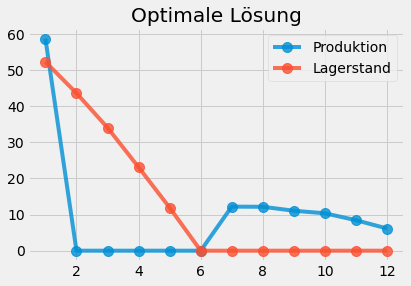

In [8]:
def plot_solution(x,s):
    fig,ax=plt.subplots(1,1)
    ax.plot(range(1,T),[xx.x for xx in x[1:]],"o-",markersize=10,label="Produktion",alpha=0.8)
    ax.plot(range(1,T),[ss.x for ss in s[1:]],"o-",markersize=10,label="Lagerstand",alpha=0.8)
    ax.legend()
    ax.set_title("Optimale Lösung")
    plt.show()
    
plot_solution(x,s)

## setup-Kosten

Nun führen wir setup-Kosten ein: Fixkosten $f_t$, die in Periode $t$ anfallen, wenn tatsächlich Produktion stattfindet. Diese Kosten können z.B. durch die nötige Reinigung der Produktionsmaschinen begründet sein. 

Das mip ergibt sich dann als:
$$
\begin{array}{lll}
\min & \sum_{t=1}^Tp_tx_t+\sum_{t=1}^Th_ts_t+\sum_{t=1}^Tf_ty_t & \\
\text{unter }& 
s_{t-1}+x_t= d_t+s_t & \qquad t=1,\ldots,T\\
&x_t\leq My_t & \qquad t=1,\ldots,T\\
&x_t,s_t\geq 0 & \qquad t=1,\ldots,T\\
&s_0=0 &\\
& y_t\in\{0,1\} & \qquad t=1,\ldots,T
\end{array}
$$
($M$ ist hier eine hinreichend große Konstante.)

Die Fixkosten setzen wir hier fest auf $10$, unabhängig vom Monat.

In [9]:
f=[10 for _ in range(T)]

Wie zuvor führen wir die Produktionsvariablen $x_t$ und die Lagervariablen $s_t$ ein. Zudem kommen Indiktorvariablen $y_t\in\{0,1\}$ hinzu, die uns anzeigen, ob im Monat $t$ produziert wird oder nicht. 

In [10]:
m2=mip.Model()
x=[m2.add_var() for _ in range(T)]
s=[m2.add_var() for _ in range(T)]
y=[m2.add_var(var_type=mip.BINARY) for _ in range(T)]

Die Zielfunktion erweitert sich um die setup-Kosten.

In [11]:
m2.objective=mip.minimize(mip.xsum(x[t]*p[t]+s[t]*h[t]+f[t]*y[t] for t in range(T)))

Dieser Teil des MIPs ist identisch mit dem LP von oben.

In [12]:
m2+=s[0]==0
m2+=x[0]==0
m2+=y[0]==0
for t in range(1,T):
    m2+=s[t]==s[t-1]-d[t]+x[t]

Wir erzwingen noch, dass die Indikatorvariablen $y_t$ tatsächlich auf $1$ gesetzt werden, wenn produziert wird. Dazu benötigen wir ein großes $M$, das wir hier auf die Summe aller Nachfragen setzen. Nie werden wir mehr produzieren wollen.

In [13]:
M=sum(d)
for t in range(1,T):
    m2+=x[t]<=M*y[t]
    
m2.optimize()

<OptimizationStatus.OPTIMAL: 0>

Wieder plotten wir die Lösung. 

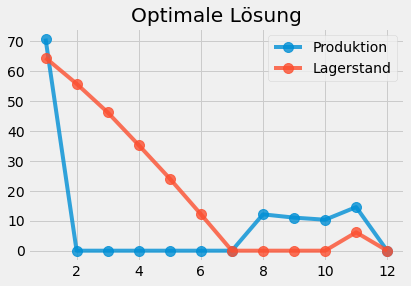

In [14]:
plot_solution(x,s)

## Kapazitäten 

Zusätzlich führen wir nun Produktions-, Lagerkapazitäten und safety stocks ein. Die Produktionskapazitäten in Periode $t$ bezeichnen wir mit $C_t$, die Lagerkapazitäten mit $r_t$ und die safety stocks (die Mindestmenge, die wir jeden Monat im Lager vorrätig halten wollen) mit $u_t$.

Das mip ergibt sich als:

$$
\begin{array}{lll}
\min & \sum_{t=1}^Tp_tx_t+\sum_{t=1}^Th_ts_t+\sum_{t=1}^Tf_ty_t & \\
\text{unter }& 
s_{t-1}+x_t= d_t+s_t & \qquad t=1,\ldots,T\\
&x_t\leq C_ty_t & \qquad t=1,\ldots,T\\
&s_t\leq r_t& \qquad t=1,\ldots, T \\
&s_t\geq u_t& \qquad t=1,\ldots,T \\
&s_0=0 &\\
&x_t,s_t\geq 0 & \qquad t=1,\ldots,T\\
& y_t\in\{0,1\} & \qquad t=1,\ldots,T
\end{array}
$$


Wir legen die Werte relativ willkürlich fest.

In [15]:
C=[25 for _ in range(T)]
r=[40 for _ in range(T)]
u=[2 for _ in range(T)]

Wir starten mit dem gleichen Modell wie oben...

In [16]:
m3=mip.Model()
x=[m3.add_var() for _ in range(T)]
s=[m3.add_var() for _ in range(T)]
y=[m3.add_var(var_type=mip.BINARY) for _ in range(T)]
m3.objective=mip.minimize(mip.xsum(x[t]*p[t]+s[t]*h[t]+f[t]*y[t] for t in range(T)))
m3+=s[0]==0
m3+=x[0]==0
m3+=y[0]==0
for t in range(1,T):
    m3+=s[t]==s[t-1]-d[t]+x[t]
M=sum(d)

...und erweitern nur um die oberen und die untere Schranke an Produktion und Lager.

In [17]:
for t in range(1,T):
    m3+=x[t]<=C[t]*y[t]
    m3+=s[t]<=r[t]
    m3+=s[t]>=u[t]
m3.optimize()

<OptimizationStatus.OPTIMAL: 0>

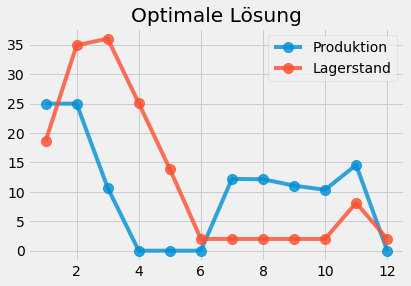

In [18]:
plot_solution(x,s)